## Finetune Mask RCNN baseline comparison model

### **Install Detectron2**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core

!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 7.5 MB/s eta 0:00:00
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
Cloning into 'detectron2'...
remote: Enumerating objects: 15737, done.
remote: Counting objects: 100% (460/460), done.
remote: Compressing objects: 100% (339/339), done.
remote: Total 15737 (delta 211), reused 305 (delta 112), pack-reused 15277
Receiving objects: 100% (15737/15737), 6.52 MiB | 15.67 MiB/s, done.
Resolving deltas: 100% (11327/11327), done.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 3.0 MB/s eta 0:0

In [3]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [4]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

Import the necessary function to register datasets in the COCO format. Let us register both the training and validation datasets.

Our dataset has been preprocessed into coco format where we have a single JSON file that describes all the annotations from all training images. <p>

Here, we are naming our training data as 'my_dataset_train' and the validation data as 'my_dataset_val'.



We have preprocessed our images into a coco json format in the preprocessing notebook. So we just import them directly here

In [5]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/IDCIA/Mask RCNN/COCO_dataset/train/coco_annotations.json", "/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/IDCIA/Mask RCNN/COCO_dataset/train")
register_coco_instances("my_dataset_val", {}, "/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/IDCIA/Mask RCNN/COCO_dataset/val/coco_annotations.json", "/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/IDCIA/Mask RCNN/COCO_dataset/val")

Let us extract the metadata and dataset dictionaries for both training and validation datasets.

In [6]:
train_metadata = MetadataCatalog.get("my_dataset_train")
train_dataset_dicts = DatasetCatalog.get("my_dataset_train")

[06/28 18:47:13 d2.data.datasets.coco]: Loading /content/drive/MyDrive/Final IDCC-SAM/Rebuttal/IDCIA/Mask RCNN/COCO_dataset/train/coco_annotations.json takes 3.60 seconds.
[06/28 18:47:13 d2.data.datasets.coco]: Loaded 145 images in COCO format from /content/drive/MyDrive/Final IDCC-SAM/Rebuttal/IDCIA/Mask RCNN/COCO_dataset/train/coco_annotations.json


In [7]:
val_metadata = MetadataCatalog.get("my_dataset_val")
val_dataset_dicts = DatasetCatalog.get("my_dataset_val")

[06/28 18:47:14 d2.data.datasets.coco]: Loaded 17 images in COCO format from /content/drive/MyDrive/Final IDCC-SAM/Rebuttal/IDCIA/Mask RCNN/COCO_dataset/val/coco_annotations.json


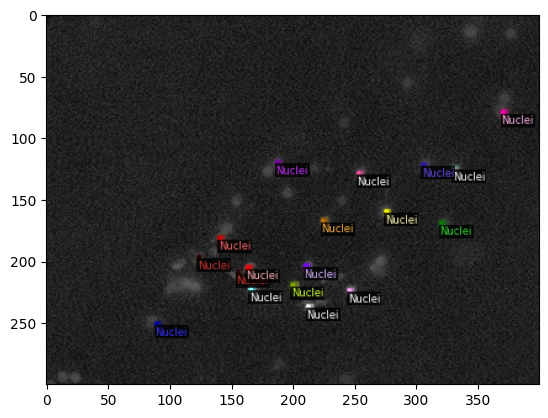

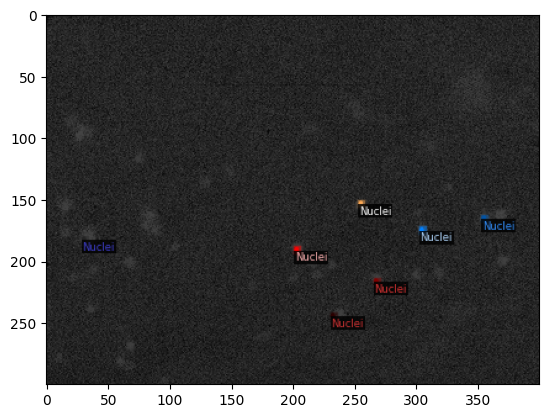

In [8]:
from matplotlib import pyplot as plt
# Visualize a random sample
for d in random.sample(train_dataset_dicts, 2):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.show()

# Train

Now we are ready to train a Mask R-CNN model using the Detectron2 library. We start by setting up a configuration file (.cfg) for the model training.

For the purpose of our fine-tuning, we use the default settings mostly. Main modifications is the number of classes.

In [9]:
from detectron2.engine import DefaultTrainer

cfg = get_cfg()
cfg.OUTPUT_DIR = "/content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models"
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # Let training initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1  # We have 1 classes, nuclei
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) #Create an instance of of DefaultTrainer with the given configuration
trainer.resume_or_load(resume=False) #Load a pretrained model if available (resume training) or start training from scratch if no pretrained model is available

[06/28 18:47:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:02, 84.8MB/s]                           
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


Train

In [10]:
trainer.train() #Start the training process

[06/28 18:47:25 d2.engine.train_loop]: Starting training from iteration 0


/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan fai

[06/28 18:47:47 d2.utils.events]:  eta: 0:05:59  iter: 19  total_loss: 4.117  loss_cls: 0.6039  loss_box_reg: 0.009764  loss_mask: 0.6938  loss_rpn_cls: 1.703  loss_rpn_loc: 1.245    time: 0.7434  last_time: 0.9889  data_time: 0.2933  last_data_time: 0.4658   lr: 9.7405e-06  max_mem: 3709M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[06/28 18:48:06 d2.utils.events]:  eta: 0:05:27  iter: 39  total_loss: 2.571  loss_cls: 0.556  loss_box_reg: 0.01382  loss_mask: 0.6933  loss_rpn_cls: 0.3221  loss_rpn_loc: 0.9906    time: 0.7419  last_time: 0.6174  data_time: 0.2580  last_data_time: 0.1535   lr: 1.9731e-05  max_mem: 3709M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[06/28 18:48:22 d2.utils.events]:  eta: 0:05:14  iter: 59  total_loss: 2.165  loss_cls: 0.4332  loss_box_reg: 0.1132  loss_mask: 0.6914  loss_rpn_cls: 0.2778  loss_rpn_loc: 0.535    time: 0.7520  last_time: 0.4885  data_time: 0.3058  last_data_time: 0.0999   lr: 2.972e-05  max_mem: 3709M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[06/28 18:48:35 d2.utils.events]:  eta: 0:04:53  iter: 79  total_loss: 1.961  loss_cls: 0.4107  loss_box_reg: 0.2041  loss_mask: 0.6879  loss_rpn_cls: 0.193  loss_rpn_loc: 0.4117    time: 0.7291  last_time: 0.4521  data_time: 0.1081  last_data_time: 0.0071   lr: 3.9711e-05  max_mem: 3709M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[06/28 18:48:46 d2.utils.events]:  eta: 0:04:18  iter: 99  total_loss: 2.005  loss_cls: 0.4756  loss_box_reg: 0.2381  loss_mask: 0.6838  loss_rpn_cls: 0.1603  loss_rpn_loc: 0.3418    time: 0.6970  last_time: 0.5560  data_time: 0.0111  last_data_time: 0.0066   lr: 4.9701e-05  max_mem: 4622M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[06/28 18:48:56 d2.utils.events]:  eta: 0:03:54  iter: 119  total_loss: 1.817  loss_cls: 0.3921  loss_box_reg: 0.2281  loss_mask: 0.6775  loss_rpn_cls: 0.1181  loss_rpn_loc: 0.3049    time: 0.6649  last_time: 0.5480  data_time: 0.0077  last_data_time: 0.0058   lr: 5.9691e-05  max_mem: 4622M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[06/28 18:49:07 d2.utils.events]:  eta: 0:03:39  iter: 139  total_loss: 1.788  loss_cls: 0.4222  loss_box_reg: 0.2534  loss_mask: 0.6734  loss_rpn_cls: 0.1534  loss_rpn_loc: 0.2747    time: 0.6478  last_time: 0.5079  data_time: 0.0111  last_data_time: 0.0065   lr: 6.9681e-05  max_mem: 4622M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[06/28 18:49:18 d2.utils.events]:  eta: 0:03:22  iter: 159  total_loss: 1.762  loss_cls: 0.3989  loss_box_reg: 0.2499  loss_mask: 0.6648  loss_rpn_cls: 0.1288  loss_rpn_loc: 0.2641    time: 0.6351  last_time: 0.4838  data_time: 0.0091  last_data_time: 0.0065   lr: 7.9671e-05  max_mem: 4622M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[06/28 18:49:30 d2.utils.events]:  eta: 0:03:10  iter: 179  total_loss: 1.767  loss_cls: 0.4446  loss_box_reg: 0.2726  loss_mask: 0.6563  loss_rpn_cls: 0.1272  loss_rpn_loc: 0.2578    time: 0.6284  last_time: 0.6037  data_time: 0.0138  last_data_time: 0.0104   lr: 8.966e-05  max_mem: 4622M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[06/28 18:49:41 d2.utils.events]:  eta: 0:02:55  iter: 199  total_loss: 1.828  loss_cls: 0.4285  loss_box_reg: 0.2798  loss_mask: 0.647  loss_rpn_cls: 0.1591  loss_rpn_loc: 0.2444    time: 0.6222  last_time: 0.4968  data_time: 0.0117  last_data_time: 0.0081   lr: 9.9651e-05  max_mem: 4622M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[06/28 18:49:52 d2.utils.events]:  eta: 0:02:41  iter: 219  total_loss: 1.746  loss_cls: 0.4255  loss_box_reg: 0.3061  loss_mask: 0.6263  loss_rpn_cls: 0.1384  loss_rpn_loc: 0.2494    time: 0.6131  last_time: 0.5108  data_time: 0.0083  last_data_time: 0.0058   lr: 0.00010964  max_mem: 4622M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[06/28 18:50:03 d2.utils.events]:  eta: 0:02:28  iter: 239  total_loss: 1.636  loss_cls: 0.3966  loss_box_reg: 0.2657  loss_mask: 0.6048  loss_rpn_cls: 0.1361  loss_rpn_loc: 0.2285    time: 0.6080  last_time: 0.5005  data_time: 0.0119  last_data_time: 0.0060   lr: 0.00011963  max_mem: 4622M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[06/28 18:50:15 d2.utils.events]:  eta: 0:02:18  iter: 259  total_loss: 1.735  loss_cls: 0.4694  loss_box_reg: 0.2889  loss_mask: 0.5755  loss_rpn_cls: 0.1435  loss_rpn_loc: 0.2327    time: 0.6078  last_time: 0.6677  data_time: 0.0166  last_data_time: 0.0102   lr: 0.00012962  max_mem: 4622M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[06/28 18:50:25 d2.utils.events]:  eta: 0:02:05  iter: 279  total_loss: 1.569  loss_cls: 0.3822  loss_box_reg: 0.2118  loss_mask: 0.5355  loss_rpn_cls: 0.1439  loss_rpn_loc: 0.238    time: 0.6017  last_time: 0.5390  data_time: 0.0091  last_data_time: 0.0178   lr: 0.00013961  max_mem: 4622M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[06/28 18:50:36 d2.utils.events]:  eta: 0:01:53  iter: 299  total_loss: 1.601  loss_cls: 0.4269  loss_box_reg: 0.2553  loss_mask: 0.5045  loss_rpn_cls: 0.1428  loss_rpn_loc: 0.2493    time: 0.5979  last_time: 0.5441  data_time: 0.0103  last_data_time: 0.0146   lr: 0.0001496  max_mem: 4622M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[06/28 18:50:47 d2.utils.events]:  eta: 0:01:41  iter: 319  total_loss: 1.485  loss_cls: 0.3679  loss_box_reg: 0.2353  loss_mask: 0.4825  loss_rpn_cls: 0.1353  loss_rpn_loc: 0.236    time: 0.5952  last_time: 0.4059  data_time: 0.0116  last_data_time: 0.0062   lr: 0.00015959  max_mem: 4622M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[06/28 18:50:59 d2.utils.events]:  eta: 0:01:30  iter: 339  total_loss: 1.485  loss_cls: 0.4081  loss_box_reg: 0.2527  loss_mask: 0.4838  loss_rpn_cls: 0.09434  loss_rpn_loc: 0.2196    time: 0.5940  last_time: 0.5773  data_time: 0.0130  last_data_time: 0.0069   lr: 0.00016958  max_mem: 4622M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[06/28 18:51:10 d2.utils.events]:  eta: 0:01:18  iter: 359  total_loss: 1.475  loss_cls: 0.3987  loss_box_reg: 0.2163  loss_mask: 0.4827  loss_rpn_cls: 0.1488  loss_rpn_loc: 0.2208    time: 0.5914  last_time: 0.6204  data_time: 0.0099  last_data_time: 0.0071   lr: 0.00017957  max_mem: 4622M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[06/28 18:51:20 d2.utils.events]:  eta: 0:01:07  iter: 379  total_loss: 1.623  loss_cls: 0.4307  loss_box_reg: 0.2784  loss_mask: 0.4695  loss_rpn_cls: 0.1427  loss_rpn_loc: 0.2584    time: 0.5881  last_time: 0.4401  data_time: 0.0088  last_data_time: 0.0054   lr: 0.00018956  max_mem: 4622M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[06/28 18:51:32 d2.utils.events]:  eta: 0:00:56  iter: 399  total_loss: 1.469  loss_cls: 0.3967  loss_box_reg: 0.2606  loss_mask: 0.4708  loss_rpn_cls: 0.1363  loss_rpn_loc: 0.2411    time: 0.5869  last_time: 0.5694  data_time: 0.0102  last_data_time: 0.0066   lr: 0.00019955  max_mem: 4622M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[06/28 18:51:42 d2.utils.events]:  eta: 0:00:44  iter: 419  total_loss: 1.468  loss_cls: 0.3628  loss_box_reg: 0.2078  loss_mask: 0.4795  loss_rpn_cls: 0.1478  loss_rpn_loc: 0.2423    time: 0.5832  last_time: 0.5617  data_time: 0.0123  last_data_time: 0.0065   lr: 0.00020954  max_mem: 4622M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

[06/28 18:51:52 d2.utils.events]:  eta: 0:00:33  iter: 439  total_loss: 1.507  loss_cls: 0.38  loss_box_reg: 0.274  loss_mask: 0.4861  loss_rpn_cls: 0.1128  loss_rpn_loc: 0.2326    time: 0.5799  last_time: 0.5230  data_time: 0.0103  last_data_time: 0.0173   lr: 0.00021953  max_mem: 4622M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[06/28 18:52:03 d2.utils.events]:  eta: 0:00:22  iter: 459  total_loss: 1.587  loss_cls: 0.4394  loss_box_reg: 0.3076  loss_mask: 0.4798  loss_rpn_cls: 0.1229  loss_rpn_loc: 0.2252    time: 0.5778  last_time: 0.4725  data_time: 0.0103  last_data_time: 0.0059   lr: 0.00022952  max_mem: 4622M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[06/28 18:52:14 d2.utils.events]:  eta: 0:00:11  iter: 479  total_loss: 1.482  loss_cls: 0.3871  loss_box_reg: 0.2724  loss_mask: 0.4832  loss_rpn_cls: 0.0918  loss_rpn_loc: 0.2262    time: 0.5760  last_time: 0.5677  data_time: 0.0102  last_data_time: 0.0106   lr: 0.00023951  max_mem: 4622M


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(


[06/28 18:52:37 d2.utils.events]:  eta: 0:00:00  iter: 499  total_loss: 1.592  loss_cls: 0.4346  loss_box_reg: 0.3  loss_mask: 0.4666  loss_rpn_cls: 0.1301  loss_rpn_loc: 0.2369    time: 0.5756  last_time: 0.4294  data_time: 0.0120  last_data_time: 0.0063   lr: 0.0002495  max_mem: 4622M
[06/28 18:52:37 d2.engine.hooks]: Overall training speed: 498 iterations in 0:04:46 (0.5756 s / it)
[06/28 18:52:37 d2.engine.hooks]: Total training time: 0:05:03 (0:00:16 on hooks)


Save the config file

In [11]:
import yaml
# Save the configuration to a config.yaml file
config_yaml_path = "/content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models/config.yaml"
with open(config_yaml_path, 'w') as file:
    yaml.dump(cfg, file)

# Inference & evaluation using the trained model

In [12]:
# Inference should use the config with parameters that are used in training
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.20   # set a custom testing threshold. We tried 10, 20, 30, 40, 50; 20 had the best performance.
cfg.TEST.DETECTIONS_PER_IMAGE = 2000  # Set the maximum number of detections per image to 2000 (this accomodate our image context well. The most dense image in our dataset is not up to 1000 cells)
predictor = DefaultPredictor(cfg)

[06/28 18:52:39 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models/model_final.pth ...


#### Verify segmentation on random validation images

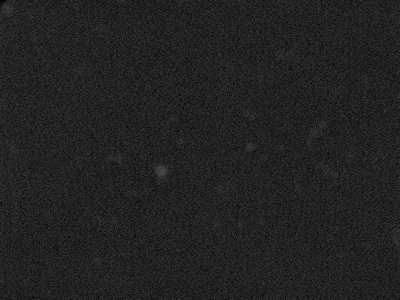

In [13]:
from detectron2.utils.visualizer import ColorMode

for d in random.sample(val_dataset_dicts, 1):    #select number of images for display
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=val_metadata,
                   scale=0.5,
                   instance_mode=ColorMode.IMAGE_BW)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

###**Load a Test image and segment it.**

[06/28 18:52:41 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/ColabNotebooks/models/Detectron2_Models/model_final.pth ...


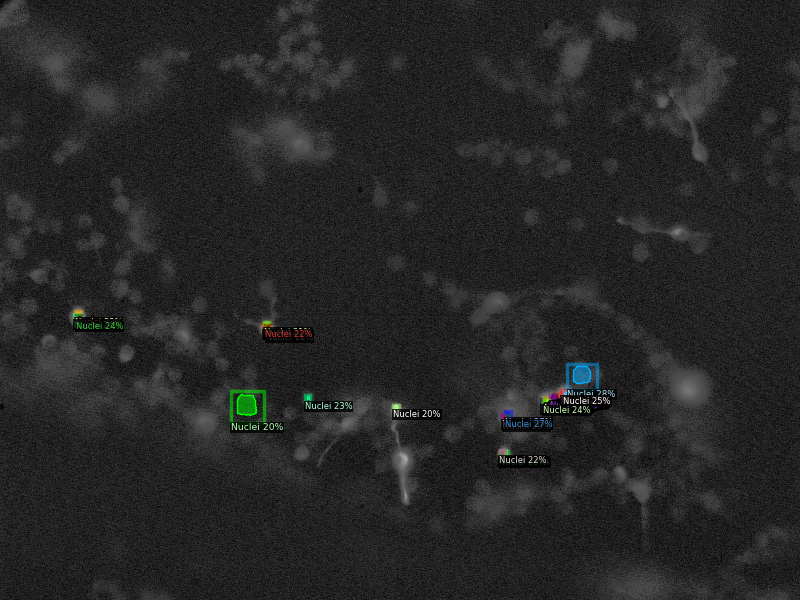

Number of instance predictions: 33


In [14]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  # path to the model we just trained
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.20   # set a custom testing threshold. We tried 10, 20, 30, 40, 50; The performance deteriorates after 20.
cfg.TEST.DETECTIONS_PER_IMAGE = 2000

predictor = DefaultPredictor(cfg)

new_im = cv2.imread("/content/drive/MyDrive/Final IDCC-SAM/Dataset/Rebuttal/IDCIA/Test_clahe/images/220909_GFP-AHPC_A_GFAP_F4_Cy3_ND2_20x.png")
outputs  = predictor(new_im)

# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

cv2_imshow(out.get_image()[:, :, ::-1])

# Get the instance predictions
instances = outputs["instances"]

# Get the number of instance predictions
num_predictions = len(instances)

print("Number of instance predictions:", num_predictions)

# print(outputs["instances"].pred_classes)
#print(outputs["instances"].pred_boxes)

###**Process multiple images in a directory and save the results in an output directory**

In [15]:

# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/Final IDCC-SAM/Dataset/Rebuttal/IDCIA/Test_clahe/images"

# Output directory where the segmented images will be saved
output_directory = "/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/IDCIA/Mask RCNN/Test Results/test_segmentation_output"

# Create the output folder if it doesn't exist
if not os.path.exists(output_directory):
    os.makedirs(output_directory)
# List of valid image extensions
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif']

# Loop over the images in the input folder
for image_filename in os.listdir(input_images_directory):
    # Check if the file has a valid image extension
    if not any(image_filename.lower().endswith(ext) for ext in valid_extensions):
        continue

    image_path = os.path.join(input_images_directory, image_filename)
    new_im = cv2.imread(image_path)

    # Perform prediction on the new image
    outputs = predictor(new_im)

    # We can use `Visualizer` to draw the predictions on the image.
    v = Visualizer(new_im[:, :, ::-1], metadata=train_metadata)
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    # Create the output filename with _result extension
    result_filename = os.path.splitext(image_filename)[0] + "_result.png"
    output_path = os.path.join(output_directory, result_filename)

    # Save the segmented image
    cv2.imwrite(output_path, out.get_image()[:, :, ::-1])

print("Segmentation of all images completed.")


/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  x = F.conv2d(
/content/detectron2/detectron2/layers/wrappers.py:142: UserWarning: Plan failed wi

Segmentation of all images completed.



###**Segment images and save object level information into a csv file.**




In [16]:
import csv
from skimage.measure import regionprops, label

# Directory path to the input images folder
input_images_directory = "/content/drive/MyDrive/Final IDCC-SAM/Dataset/Rebuttal/IDCIA/Test_clahe/images"

# Output directory where the CSV file will be saved
output_csv_path = "/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/IDCIA/Mask RCNN/Test Results/test_segmentation_output/output_objects.csv"

# Extract the directory name from the full path
output_dir_name = os.path.dirname(output_csv_path)

# Check if the directory exists
if not os.path.exists(output_dir_name):
    # If not, create the directory
    os.makedirs(output_dir_name)


# List of valid image extensions.
valid_extensions = ['.jpg', '.jpeg', '.png', '.bmp', '.tiff', '.gif']

# Open the CSV file for writing
with open(output_csv_path, 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)

    # Write the header row in the CSV file
    csvwriter.writerow(["File Name", "Class Name", "Object Number", "Area", "Centroid", "BoundingBox"])

    # Loop over the images in the input folder
    for image_filename in os.listdir(input_images_directory):
        # Check if the file has a valid image extension
        if not any(image_filename.lower().endswith(ext) for ext in valid_extensions):
            continue

        image_path = os.path.join(input_images_directory, image_filename)
        new_im = cv2.imread(image_path)

        # Perform prediction on the new image
        outputs = predictor(new_im)

        # Convert the predicted mask to a binary mask
        mask = outputs["instances"].pred_masks.to("cpu").numpy().astype(bool)

        # Get the predicted class labels
        class_labels = outputs["instances"].pred_classes.to("cpu").numpy()

        # Use skimage.measure.regionprops to calculate object parameters
        labeled_mask = label(mask)

        # Check if any regions are detected
        if np.any(labeled_mask):
            props = regionprops(labeled_mask)

            # Write the object-level information to the CSV file
            for i, prop in enumerate(props):
                object_number = i + 1
                area = prop.area
                centroid = prop.centroid
                bounding_box = prop.bbox

                # Check if the corresponding class label exists
                if i < len(class_labels):
                    class_label = class_labels[i]
                    class_name = train_metadata.thing_classes[class_label]
                else:
                    class_name = 'Unknown'

                csvwriter.writerow([image_filename, class_name, object_number, area, centroid, bounding_box])
        else:
            # Handle case where no regions are detected (empty mask)
            # Populate CSV with default information for one object
            default_object_number = 1
            default_area = 0  #
            default_centroid = (0, 0)  #
            default_bounding_box = (0, 0, 0, 0)  #
            default_class_name = 'Unknown'

            csvwriter.writerow([image_filename, default_class_name, default_object_number, default_area, default_centroid, default_bounding_box])

print("Object-level information saved to CSV file.")


Object-level information saved to CSV file.


###**Generate plots to visualize the density of segmented cells across the images**

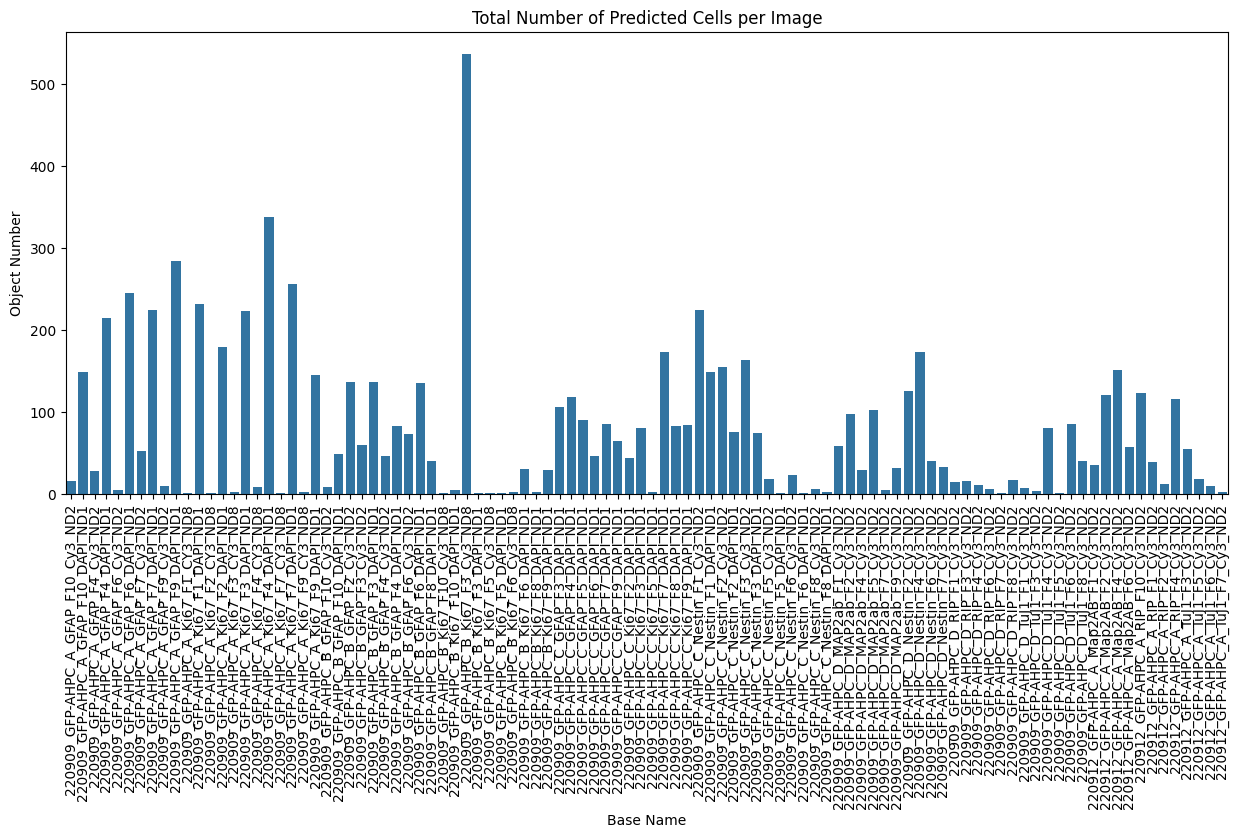

In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/IDCIA/Mask RCNN/Test Results/test_segmentation_output/output_objects.csv")

# 1. number of Nuclei per image for each unique 'File Name'.
# Extract the base name from the file name (excluding the number)
df['Base Name'] = df['File Name'].str.rsplit('_', n=1).str[0]

# Group by the base name and compute the total number of non-empty object numbers per image
total_nuclei_per_base_name = df.groupby('Base Name')['Object Number'].apply(lambda x: (x != 0).sum()).reset_index()

# Plot the total number of non-empty object numbers per image
plt.figure(figsize=(15, 6))
sns.barplot(data=total_nuclei_per_base_name, x='Base Name', y='Object Number')
plt.title('Total Number of Predicted Cells per Image')
plt.xticks(rotation=90)
plt.show()


### Now let's analyze the predictions, compare it to ground truths, and save the prediction summary in an excel file

In [18]:
import pandas as pd

# Load the CSV file into a Pandas DataFrame
df = pd.read_csv("/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/IDCIA/Mask RCNN/Test Results/test_segmentation_output/output_objects.csv")

# Extract the base name from the file name (excluding the number)
df['Base Name'] = df['File Name'].str.rsplit('_', n=1).str[0]

# Group by the base name and compute the total number of non-empty object numbers per image
total_nuclei_per_base_name = df.groupby('File Name')['Object Number'].apply(lambda x: (x != 0).sum()).reset_index()
total_nuclei_per_base_name.columns = ['File Name', 'Total Nuclei']

# Load the ground truth Excel file
ground_truth_df = pd.read_csv('/content/drive/MyDrive/Final IDCC-SAM/Dataset/Rebuttal/IDCIA/ground_truth.csv')

# Merge the total nuclei counts with the ground truth data
merged_df = pd.merge(total_nuclei_per_base_name, ground_truth_df, left_on='File Name', right_on='image name')

# Calculate the absolute difference and absolute percentage accuracy
merged_df['Absolute Difference'] = (merged_df['Total Nuclei'] - merged_df['ground truth']).abs()
merged_df['Absolute Percentage Accuracy'] = (1 - merged_df['Absolute Difference'] / merged_df['ground truth']) * 100

# Rename columns and create the new column "AAE <=10"
merged_df.rename(columns={'Total Nuclei': 'Prediction', 'Absolute Difference': 'Raw Absolute Error'}, inplace=True)
merged_df['AAE <=10'] = merged_df['Raw Absolute Error'].apply(lambda x: 'Yes' if x <= 10 else 'No')

# Drop unnecessary columns
merged_df.drop(columns=['image name'], inplace=True)

# Reorder columns
final_df = merged_df[['File Name', 'ground truth', 'Prediction', 'Raw Absolute Error', 'AAE <=10']]
final_df.rename(columns={'ground truth avg': 'Ground Truth', 'File Name': 'Image Name'}, inplace=True)
final_df = final_df.sort_values(by='Raw Absolute Error', ascending=True)

# Save the final DataFrame to a new prediction summary Excel file
summary_excel_path = '/content/drive/MyDrive/Final IDCC-SAM/Rebuttal/IDCIA/Mask RCNN/Mask RCNN_prediction_summary_IDCIA.xlsx'
final_df.to_excel(summary_excel_path, index=False)

# Display the final DataFrame
print(final_df)


<ipython-input-18-7e428bca2f94>:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df.rename(columns={'ground truth avg': 'Ground Truth', 'File Name': 'Image Name'}, inplace=True)


                                     Image Name  ground truth  Prediction  \
60  220909_GFP-AHPC_C_Nestin_F5_Cy3_ND2_20x.png          19.0          18   
36    220909_GFP-AHPC_B_Ki67_F5_Cy3_ND8_20x.png           2.0           1   
47   220909_GFP-AHPC_C_GFAP_F9_DAPI_ND1_20x.png          64.0          65   
53   220909_GFP-AHPC_C_Ki67_F9_DAPI_ND1_20x.png          83.0          84   
39   220909_GFP-AHPC_B_Ki67_F6_DAPI_ND1_20x.png          32.0          31   
..                                          ...           ...         ...   
24    220909_GFP-AHPC_B_GFAP_F2_Cy3_ND2_20x.png           2.0         137   
3    220909_GFP-AHPC_A_GFAP_F4_DAPI_ND1_20x.png         353.0         215   
17   220909_GFP-AHPC_A_Ki67_F4_DAPI_ND1_20x.png         554.0         338   
5    220909_GFP-AHPC_A_GFAP_F6_DAPI_ND1_20x.png         477.0         246   
34    220909_GFP-AHPC_B_Ki67_F3_Cy3_ND8_20x.png           0.0         537   

    Raw Absolute Error AAE <=10  
60                 1.0      Yes  
36     

# END